<a href="https://colab.research.google.com/github/nuyhc/RhythmStudy/blob/main/1.%20PyTorch/PTM_4_%EB%B0%95%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [PTM] 8장. 컨볼루션을 활용한 일반화

앞서 7장에서는 선형 계층에 존재하는 최적화를 위해 활용 가능한 여러 파라미터의 도움으로 데이터에 맞춘(혹은 과적합된) 단순 신경망을 만들었다.
* 일반화를 강제하기 위해 훈련 데이터를 증강시켜도 너무 많은 파라미터가 필요하다.
* 더 나은 방법은, 신경망에서 완전 연결된 아핀 변환 유닛을 또 다른 선형 연산인 컨볼루션으로 바꾸는 것이다.

In [1]:
!git clone https://github.com/deep-learning-with-pytorch/dlwpt-code

Cloning into 'dlwpt-code'...
remote: Enumerating objects: 703, done.
remote: Total 703 (delta 0), reused 0 (delta 0), pack-reused 703
Receiving objects: 100% (703/703), 176.00 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (309/309), done.
Checking out files: 100% (228/228), done.


## 8.1 컨볼루션

* 하늘을 나는 비행기 같은 물체와 일치하는 패턴을 인지하려면 인근 픽셀의 배열 방식을 살펴봐야 한다.
* 서로 멀리 떨어져 있는 픽셀들을 연결해가며 어떻게 보이는지 확인하는 데에는 관심이 없다.  

**즉, 스핏파이어가 등장하는 이미지에 나무나 구름 혹은 연 같은 물체가 구석에 있는지 관심이 없다는 뜻이다.**

* 이 개념을 수학적인 형태로 바꾸려면 이미지 내의 다른 픽셀이 아닌 바로 옆 픽셀에 대한 가중치의 합을 계산하면 된다.  
* 센터가 되는 픽셀에서 일정 거리 이상 떨어진 경우 가중치가 0이 된다고 생각하면 된다.


### 8.1.1 컨볼루션의 역할

`평행이동 불변성(translate invariance)`은 지역화된 패턴이 이미지의 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질이다.
이미지를 벡터처럼 다루려고 만들었던 행렬로 이러한 효과를 내려면 다소 복잡한 가중치 패턴을 구현해야 한다.  
* 따라서, 같은 값으로 초기화해야 하며 가중치가 훈련을 통해 업데이트시 영향을 받지 않아야 한다는 의미다. 


이미지에 대해 `지역적인`, `평행이동 불변성`을 보장하는 선형 연산도 이미 존재하는데 `컨볼루션(convolution)` 이다.   
정확하게 말하자면 `이산 컨볼루션(discrete convolution)`은 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것으로 정의한다. 가중치 행렬은 `커널(kernel)`이라 부르며 입력의 모든 이웃에 대해 수행한다.


*`지역성(locality)` 이동된 커널과 이미지(커널 밖은 0의 값을 가짐)의 스칼라곱이다.*

### 컨볼루션 사용시
* 주의 영역에 대한 지역 연산을 할 수 있고
* 평행이동 불변성을 가지며
* 더 적은 파라미터를 사용한다.

## 8.2 컨볼루션 사용해보기

torch.nn 모듈은 1, 2, 3차원에 대한 컨볼루션을 제공한다.  
* nn.Conv1d는 시계열용
* nn.Conv2d는 이미지용
* nn.Conv3d는 용적 데이터나 동영상용

**nn.Conv2d(최소 입력 피처 수, 출력 피처 수, 커널의 크기)**
* 최소 입력 피처 수: 픽셀 하나당 둘 이상의 값을 가지는 `멀티채널` 이미지의 경우 `채널` 정보  
* 출력 피처 수: 출력 이미지가 더 많은 채널을 가질수록 신경망의 용량도 커짐
* 커널의 크기: 일반적으로 모든 방향으로 동일하게 만듬
    * 2차원 컨볼루션 -> 3X3
    * 3차원 컨볼루션 -> 3X3X3
    * 2부에서 살펴볼 CT 스캔 데이터는 세 개의 축 중 하나가 다른 Voxel(3D)화소임

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 입력 피처 수 -> 3 (RGB 채널을 가지니 픽셀당 3개의 입력 피처)
# 출력 피처 수 -> 16 (임의로 16을 전달/ 출력 이미지가 더 많은 채널을 가질수록 신경망의 용량도 커짐)
# 커널의 크기 

conv = nn.Conv2d(3, 16, kernel_size=3)  # kernel_size=(3, 3)을 전달해도 동일한 효과
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

전체 가중치 텐서는 `out_chXin_chX3X3` -> 즉, 16X3X3X3

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
from torchvision import datasets, transforms

data_path = '/content/dlwpt-code/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/dlwpt-code/p1ch7/cifar-10-python.tar.gz to /content/dlwpt-code/p1ch7
Files already downloaded and verified


2차원 컨볼루션 전달은 2차원 이미지를 출력한다.
출력 픽셀은 입력 이미지의 각 이웃 데이터에 대한 가중치 합니다.
커널 가중치와 편향값 conv.weight가 랜덤으로 초기화된다.
* 따라서, 출력 이미지 자체가 특별한 의미를 갖지 않는다.

하나의 입력 이미지로 conv 모듈을 호출하려면 nn.Conv2d는 입력으로 BXCXHXW를 받으므로 통상 0번째 차원은 unsqueeze를 통해 배치 차원으로 사용된다.

```python
>>> x = torch.tensor([1, 2, 3, 4])
>>> torch.unsqueeze(x, 0)
tensor([[ 1,  2,  3,  4]])
>>> torch.unsqueeze(x, 1)
tensor([[ 1],
        [ 2],
        [ 3],
        [ 4]])
```

In [5]:
import torch.optim as optim

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

# 출력 이미지 자체가 특별한 의미를 갖지 않음/ 출력 이미지 -> 1
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

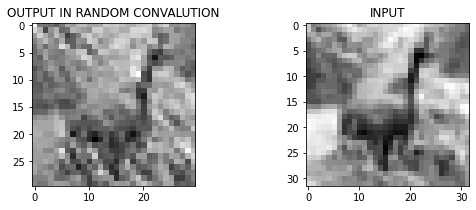

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 3))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(output[0, 0].detach(), cmap='gray')
ax1.title.set_text('OUTPUT IN RANDOM CONVALUTION')
ax2.imshow(img.permute(1, 2, 0)[:, :, 0], cmap='gray')
ax2.title.set_text('INPUT')
plt.show()

### 8.2.1  경계 패딩하기

컨볼루션에서 `패딩`을 사용하는 이유
* 패딩을 통해서 컨볼루션과 이미지 크기 변경 문제는 별도로 분리해 기억해야 하는 사항을 하나 줄이는 데 도움을 줌
* 컨볼루션 구조 자체에 더 신경쓸 수 있음

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)  # 패딩시킴
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### 8.2.2  컨볼루션으로 피처 찾아내기

weight와 bias는 역전파를 통해 학습되는 파라미터라고 배웠다. 정확하게는 nn.Linear에서 일어난다. 하지만, 이와 다르게 직접 가중치를 설정해서 컨볼루션에서 어떤 일이 일어나는지 알아볼 수도 있다.

* 먼저 bias를 0으로 제거해 `교란 변수`를 배제하자.
* 가중치에 상수값을 넣어서 출력의 각 픽셀이 자신의 이웃 픽셀에 대한 평균을 가지게 해보자.


In [8]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

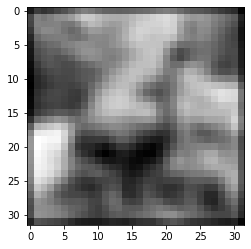

In [9]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

아래 이미지가 흐려졌다. 각 출력 픽셀은 자신의 주변 픽셀에 대한 평균이기 때문에 출력 픽셀에서 이러한 상관관계를 반영해 픽셀 간의 변화가 부드러워졌다.

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

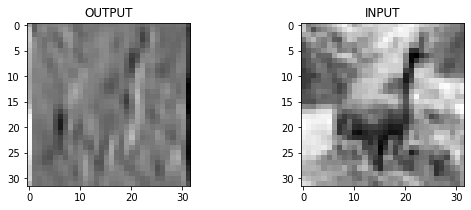

In [11]:
import matplotlib.pyplot as plt

output = conv(img.unsqueeze(0))

fig = plt.figure(figsize=(9, 3))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(output[0, 0].detach(), cmap='gray')
ax1.title.set_text('OUTPUT')
ax2.imshow(img.permute(1, 2, 0)[:, :, 0], cmap='gray')
ax2.title.set_text('INPUT')
plt.show()

### 8.2.3  깊이와 풀링으로 한 단계 더 인식하기

큰 이미지에서 작은 이미지로: 다운샘플링
* `네 개의 픽셀을 평균하기`: 초기에는 이와 같은 **평균 풀링**average pooling이라는 방법이 일반적이었는데 요즘은 잘 사용하지 않는다.
* `네 개의 픽셀 중 최댓값`: **맥스 풀링**max pooling이라 불리는 이와 같은 접근 방법은 오늘날 가장 널리 사용되지만, 데이터의 4분의 3을 버린다는 단점이 있다.
* `스트라이드하며 컨볼루션을 수행하되 n번째 픽셀만 계산하기`: 3X4 컨볼루션을 스트라이드 2로 실행하면 이전 계층의 모든 픽셀을 포함한되. 이 방식의 가능성을 보여주는 논문이 있지만 아직 맥스 풀링을 대체할 정도는 아니다.

In [12]:
pool = nn.MaxPool2d(2)  # 컨볼루션과 마찬가지로 1차원과 3차원 데이터를 위한 버전도 있다.
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### 8.2.4  우리의 신경망에 적용하기

우리가 지금 만들고 있는 전형적인 컨볼루션 신경망의 모양.
* 이미지가 여러 개의 연속적인 컨볼루션과 맥스 풀링 모듈을 거친 후 1차원 벡터로 나열되고 이내 완전 연결 모듈로 들어간다.

In [13]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... 8채널의 8X8 이미지를 1차원 벡터로 바꿔서 완전 연결 계층으로 신경망을 마무리해야 함.
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2),       
)

In [14]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [15]:
model(img.unsqueeze(0))  # 경고

RuntimeError: ignored

모델을 살펴보면 512X32 텐서를 가지는 모듈은 마지막 컨볼루션 블럭 다음에 오는 첫째 선형 모듈인 nn.Linear(512, 32)뿐이다.  
* 하나 깜빡한 부분은 8채널의 8X8 이미지를, 512요소를 가진 1차원 벡터로 차원 정보를 변경해야하는 부분이다.
* 마지막 nn.MaxPool2d의 출력에 대해 view를 호출하면 해결할 수 있다.
* `nn.Sequential을 사용할 때는 각 모듈의 출력을 명시적으로 볼 수 없다.`

## 8.3 nn.Module 서브클래싱하기

신경망 개발하다 보면 기존에 만들어진 모듈에서 지원하지 않는 연산이 필요할 떄가 있다.
* 차원 정보 변경, 잔차 연결 구현
* `nn.Module`의 서브클래스를 직접 만드는 법을 배워서 이미 만들어져 있는 것이나 `nn.Sequential`처럼 사용할 수 있게 할 예정

nn.Module을 서브클래싱하기
1. 먼저 forward 함수를 정의하여 모듈로 입력을 전달하고 출력을 반환하게 해야 함
2. 파이토치에서는 표준 torch 연산을 사용하기만 한다면 자동미분 기능이 자동으로 역방향 경로를 만들어준다. (nn.Module에는 backward가 필요 없다.)
3. 우리가 만들 연산도 결국 컨볼루션 같은 이미 있는 모듈이나 커스텀 모듈을 사용한다.
4. 서브모듈을 포함하려면 생성자 __init__에 정의하고 self에 할당해서 forward 함수에서 사용할 수 있게 만들어야 한다.
5. 모든 코드에 앞서 super().__init__()을 호출해야 함을 잊지 말자. 

### 8.3.1 nn.Module로 정의된 우리의 신경망

self.pool3의 출력을 직접 조작해서 view를 통해 BXN 벡터로 만들 수 있다.

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1))
        out = self.pool2(self.act2(self.conv2))
        out = out.view(-1, 8*8*8)  # view(512D)
        out = self.act3(self.fc1(out))  # Linear(512D -> 32D) -> Tanh
        out = self.fc2(out)  # OUTPUT 2D
        return out

### 8.3.2 파이토치가 파라미터와 서브모듈을 유지하는 방법

In [17]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### 8.3.3 함수형 API

Net 클래스 구현을 되돌아보고 생성자에서 서브모듈을 등록하는 과정을 생각해보면 파라미터가 없는 nn.Tanh(), nn.MaxPool2d 같은 서브 모듈은 굳이 등록할 필요가 없을 것 같다. 이들은 view 호출처럼 그냥 forward 함수에서 직접 호출하는 게 더 쉽지 않을까?
* 그런 이유로 파이토치는 모든 nn 모듈에 대한 함수형을 제공한다.
* 여기서 '함수형'이란 내부 상태가 없다는 의미다. 즉. 출력값이 전적으로 입력 인자에 의존한다.

예를 들어, nn.Linear의 함수형은 `nn.functional.linear`인데,   
함수 시그니처가 `linear(input, weight, bias=None)`이다. 함수 인자로 weight와 bias가 넘어간다.

In [18]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)    
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0502, -0.0222]], grad_fn=<AddmmBackward0>)

## 8.4 우리가 만든 컨볼루션 신경망 훈련시키기

우리가 만든 컨볼루션 신경망을 두 루프를 가지고 있다.   
바깥 루프는 에포크 단위로 돌며, 안쪽 루프는 `Dataset`에서 배치를 만드는 `DataLoader` 단위로 돈다.  

> 각 루프에서  
    1. 모델에 입력값을 넣고(순방향 전달)
    2. 손실값을 계산하고(마찬가지로 순방향 전달)  
    3. 이전 기울기값을 0으로 리셋하고  
    4. loss.backward()를 호출하여 모든 파라미터에 대한 손실값의 기울기를 계산한다(역방향 전달).  
    5. 이후 옵티마이저를 통해 손실값을 낮추도록 파라미터를 조정한다.

In [20]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-01-04 06:33:52.128896 Epoch 100, Training loss 0.22351231169738586


### 8.4.1 정확도 측정
손실값보다 해석하기 좋은 측정 방법으로 훈련셋과 검증셋을 통한 정확도 측정을 생각해볼 수 있다.

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)  # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.89


* <1>: 파라미터를 업데이트하지 않을 것이므로 기울기는 필요없다.
* <2>: 가장 높은 값을 가진 인덱스를 출력한다.
* <3>: 예제 수를 세어서 total을 배치 크기만큼 증가시킨다.
* <4>: 확률값이 가장 높았던 클래스의 레이블의 실측값을 비교하여 불리언 배열을 얻고, 예측값이 실측값에 맞는 경우가 배치에서 얼마나 나왔는지 세어 합한다.

### 8.4.2 모델을 저장하고 불러오기

model의 모든 파라미터를 pt형식으로 저장

In [23]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

실제 서비스 목적으로 제공한다면 model 클래스도 보관해뒀다가 인스턴스를 만들고 파라미터를 파일에서 읽어와야 한다.

In [24]:
loaded_model =Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3  GPU에서 훈련시키기

GPU로 옮길 수 있는 것들 - .to 메소드 사용
* 데이터 로더에서 얻은 텐서
* 파라미터
* nn.Module

Module.to와 Tensor.to는 사실 조금 다르다. Module.to는 모듈 인스턴스 자체를 수정한다. 하지만 Tensor.to는 새 텐서를 반환한다. 파라미터를 원하는 디바이스로 이동 후 Optimizer를 만드는 식의 구현을 추천한다.

In [25]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [26]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # input의 labels를 옮기는 이 두 줄만 이전과 다르다.
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

vaildate 함수에서도 동일한 방식의 수정이 필요하다. 이후 모델을 인스턴스화하고 device로 옮긴 후 이전처럼 실행한다.

In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2023-01-04 06:36:30.174224 Epoch 1, Training loss 0.6853811376413722
2023-01-04 06:36:33.491752 Epoch 10, Training loss 0.47094707637076166
2023-01-04 06:36:37.124681 Epoch 20, Training loss 0.38460718864088606
2023-01-04 06:36:40.758224 Epoch 30, Training loss 0.3360207164363497
2023-01-04 06:36:44.420108 Epoch 40, Training loss 0.31678117631347313
2023-01-04 06:36:48.106108 Epoch 50, Training loss 0.29901218338377156
2023-01-04 06:36:51.747760 Epoch 60, Training loss 0.28089636602219503
2023-01-04 06:36:55.419472 Epoch 70, Training loss 0.2652488572961965
2023-01-04 06:36:59.095480 Epoch 80, Training loss 0.2545768981146964
2023-01-04 06:37:02.775538 Epoch 90, Training loss 0.24189810483318985
2023-01-04 06:37:06.458005 Epoch 100, Training loss 0.22483034972931928


# [PTM] 9장. 암과 싸워 이기기 위한 파이토치 활용